In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional
import matplotlib

sns.set_context("notebook", font_scale=1)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Nimbus Sans'

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

from IPython.display import display

%matplotlib inline

def restore_minor_ticks_log_plot(
    ax: Optional[plt.Axes] = None, n_subticks=9
) -> None:
    """For axes with a logrithmic scale where the span (max-min) exceeds
    10 orders of magnitude, matplotlib will not set logarithmic minor ticks.
    If you don't like this, call this function to restore minor ticks.

    Args:
        ax:
        n_subticks: Number of Should be either 4 or 9.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()
    # Method from SO user importanceofbeingernest at
    # https://stackoverflow.com/a/44079725/5972175
    locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(
        base=10.0, subs=np.linspace(0, 1.0, n_subticks + 2)[1:-1], numticks=1000
    )
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

In [2]:
def generate_l2fc(annotation, deseq, biotype, gabel=False):
    df = pd.read_csv(annotation, sep="\t", index_col=3, header=None)
    df.index = [i.split(".")[0] for i in df.index]
    df.columns = ["chromosome", "start", "end", "other_chromosome", "strand"]
    
    deseq_df = pd.read_csv(deseq, sep="\t", index_col=0)
    deseq_df.index = [i.split(".")[0] for i in deseq_df.index]
    l2fc = pd.concat([df, deseq_df], axis=1)
    l2fc = l2fc.loc[l2fc["log2FoldChange"].dropna().index]   
    
    biotype = pd.read_csv(biotype, sep="\t", header=None, index_col=0)
    l2fc["biotype"] = biotype[1]
    
    l2fc = l2fc[l2fc["biotype"]=="protein_coding"]
    if gabel:
        l2fc = l2fc[l2fc["pvalue"]<0.05]
    else:
        l2fc = l2fc[l2fc["padj"]<0.05]
    return l2fc

def add_methylation(l2fc, intersect_files, bins=30):
    for file, context in zip(intersect_files, ["mCAC", "mCAC except CAn", "mCA CAn"]):
        d = pd.read_csv(file, sep="\t", header=None, index_col=3, low_memory=False)[6].replace(".", np.nan).astype(float).dropna()    
        d.index = [i.split(".")[0] for i in d.index]    
        l2fc[context] = d    
        l2fc[f"{context} bins"] = pd.qcut(l2fc[context], bins, duplicates="drop")
    for file, context in zip([intersect_files[-1]], ["CAn"]):
        d = pd.read_csv(file, sep="\t", header=None, low_memory=False).groupby(3).sum()[9]
        d.index = [i.split(".")[0] for i in d.index]
        l2fc["CAn"] = d
    l2fc["gene length"] = l2fc["end"]-l2fc["start"]
    l2fc["gene length bins"] = pd.qcut(l2fc["gene length"], bins, duplicates="drop")
    l2fc["percentage CAn"] = (l2fc["CAn"] / l2fc["gene length"]) * 100
    l2fc["percentage CAn bins"] = pd.qcut(l2fc["percentage CAn"], bins, duplicates="drop") 
    
    return l2fc.dropna()

def mean_std_err(df, groupby="percentage CAn bins"):
    mean = df.groupby(groupby).mean()
    std = df.groupby(groupby).sem()
    return mean, std

def plot(ax, l2fc, logx=True, groupby="percentage CAn bins", ylabel=True):
    mean, std = mean_std_err(l2fc, groupby=groupby)
    r = l2fc[[groupby.split(" bins")[0], "log2FoldChange"]].dropna().corr(method="spearman").values[0][1]
    ax.errorbar(x=mean[groupby.split(" bins")[0]].values,
                y=mean["log2FoldChange"].values,
                xerr=std[groupby.split(" bins")[0]].values,
                yerr=std["log2FoldChange"].values,
                fmt="o", color="black", markersize=6, markeredgecolor="white", linewidth=1)    
    ax.set_xlabel("")
    ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)
    ax.text(0.05, 0.95, r"$\mathregular{R^2}=$"+"{:.2f}".format(r*r), transform=ax.transAxes, va='top')
    
    if ylabel:    
        ax.set_ylabel(r"$\mathregular{log_2}$" " fold change")
    
    if logx:
        ax.set_xscale("log")
        restore_minor_ticks_log_plot(ax)    

# 2. Add methylation quantification for gene bodies

> Please complete the wgbs workflow before executing the cells below. The wgbs workflow executes commands to generate methylation quantification files which will be queried.

## 2.1 Chen et al. (2015) RNAseq and Lagger et al. (2015) WGBS (Hypothalamus)

In [3]:
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE84533/GSE84533_hypothalamus_rep123.CAC.5.bedGraph.gz -c 4 -o sum > methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAC.sum.tsv
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE84533/GSE84533_hypothalamus_rep123.CAC.5.subtract.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAC.subtract.CAn.sum.tsv
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE84533/GSE84533_hypothalamus_rep123.CA.5.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAn.sum.tsv
!bedtools intersect -a annotation/mus_musculus/mm9.genes.bed -b ../methods/data/mm9.CAn.bed -wo > methylation/GSE66870_mRNA_seq_CAn.tsv

In [4]:
_l2fc = generate_l2fc("annotation/mus_musculus/mm9.genes.bed", "DESeq2/GSE66870/ko_vs_wt.tsv", "annotation/mus_musculus/gene_biotype.txt")

l2fc = add_methylation(_l2fc, ["methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAC.sum.tsv",
     "methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAC.subtract.CAn.sum.tsv",
     "methylation/GSE66870_mRNA_seq_GSE84533_hypothalamus_rep123.CAn.sum.tsv", "methylation/GSE67294_mRNA_seq_CAn.tsv"])

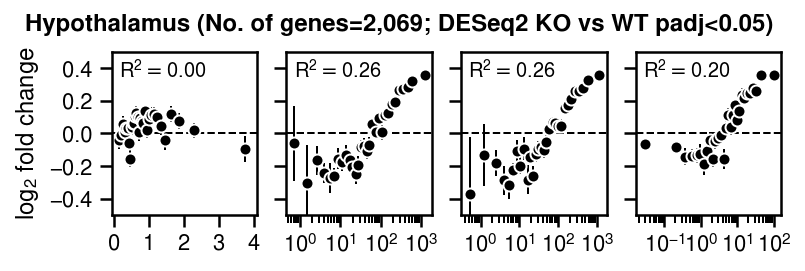

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(6, 1.5), sharey=True)

for ax, groupby, logx, ylabel in zip(axes, 
    ["percentage CAn bins", "mCAC bins", "mCAC except CAn bins", "mCA CAn bins"],
    [False, True, True, True], [True, False, False, False]):
    plot(ax, l2fc, logx=logx, groupby=groupby, ylabel=ylabel)        
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_ylim(-.5, .5)
axes[0].set_yticks([-.4, -.2, 0, .2, .4])
_ = axes[0].text(0.025, 0.975, "Hypothalamus (No. of genes={:,}; DESeq2 KO vs WT padj<0.05)".format(len(l2fc)), fontweight="bold",
                transform=fig.transFigure, fontsize="large")
fig.savefig("plots/hypothalamus.pdf")

## 2.2 Gabel et al. (2015) RNAseq and Lister et al. (2015) WGBS (Cortex)

In [6]:
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE47966/GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.10.bedGraph.gz -c 4 -o sum > methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.sum.tsv
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE47966/GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.10.subtract.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.subtract.CAn.sum.tsv
!bedtools map -a annotation/mus_musculus/mm9.genes.bed -b ../wgbs/GSE47966/GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CA.10.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAn.sum.tsv
!bedtools intersect -a annotation/mus_musculus/mm9.genes.bed -b ../methods/data/mm9.CAn.bed -wo > methylation/GSE67294_mRNA_seq_CAn.tsv

In [7]:
_l2fc = generate_l2fc("annotation/mus_musculus/mm9.genes.bed", "DESeq2/GSE67294/ko_vs_wt.tsv", "annotation/mus_musculus/gene_biotype.txt", gabel=True)

l2fc = add_methylation(_l2fc, ["methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.sum.tsv",
     "methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAC.subtract.CAn.sum.tsv",
     "methylation/GSE67294_mRNA_seq_GSE47966_MethylC-Seq_mm_fc_male_7wk_neun_pos.CAn.sum.tsv", "methylation/GSE67294_mRNA_seq_CAn.tsv"])

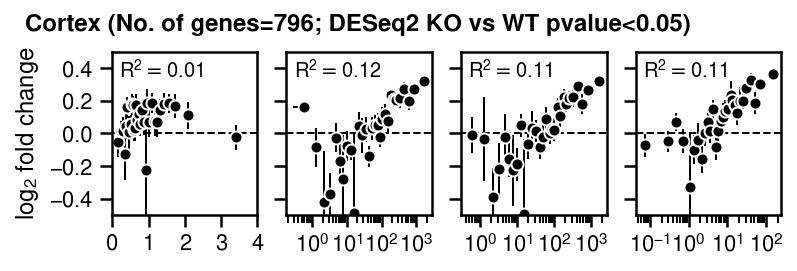

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(6, 1.5), sharey=True)

for ax, groupby, logx, ylabel in zip(axes, 
    ["percentage CAn bins", "mCAC bins", "mCAC except CAn bins", "mCA CAn bins"],
    [False, True, True, True], [True, False, False, False]):
    plot(ax, l2fc, logx=logx, groupby=groupby, ylabel=ylabel)
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_yticks([-.4, -.2, 0, .2, .4])
_ = axes[0].text(0.025, 0.975, "Cortex (No. of genes={:,}; DESeq2 KO vs WT pvalue<0.05)".format(len(l2fc)), fontweight="bold",
                transform=fig.transFigure, fontsize="large")
fig.savefig("plots/cortex.pdf")

## 2.3 Boxer et al. (2020) RNAseq and Boxer et al. (2020) WGBS (Forebrain)

In [9]:
!bedtools map -a annotation/mus_musculus/genes.bed -b ../wgbs/GSE128172/GSE128172_MeCP2_WT_OX_rep123.CAC.5.bedGraph.gz -c 4 -o sum > methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAC.sum.tsv
!bedtools map -a annotation/mus_musculus/genes.bed -b ../wgbs/GSE128172/GSE128172_MeCP2_WT_OX_rep123.CAC.5.subtract.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAC.subtract.CAn.sum.tsv
!bedtools map -a annotation/mus_musculus/genes.bed -b ../wgbs/GSE128172/GSE128172_MeCP2_WT_OX_rep123.CA.5.CAn.bedGraph.gz -c 4 -o sum > methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAn.sum.tsv
!bedtools intersect -a annotation/mus_musculus/genes.bed -b ../methods/data/mm10.CAn.bed -wo > methylation/GSE128178_mRNA_seq_CAn.tsv

In [10]:
_l2fc = generate_l2fc("annotation/mus_musculus/genes.bed", "DESeq2/GSE128178/ko_vs_wt.tsv", "annotation/mus_musculus/gene_biotype.txt")

l2fc = add_methylation(_l2fc, ["methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAC.sum.tsv",
     "methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAC.subtract.CAn.sum.tsv",
     "methylation/GSE128178_mRNA_seq_GSE128172_MeCP2_WT_OX_rep123.CAn.sum.tsv", "methylation/GSE128178_mRNA_seq_CAn.tsv"])

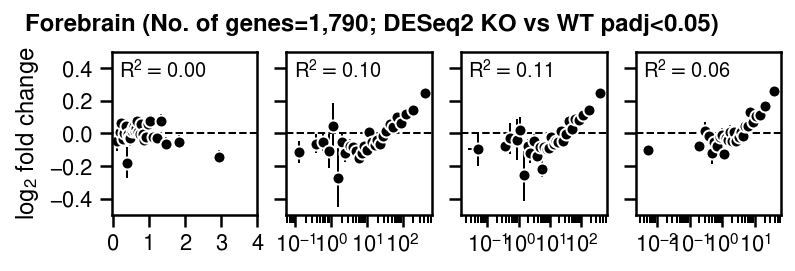

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(6, 1.5), sharey=True)

for ax, groupby, logx, ylabel in zip(axes, 
    ["percentage CAn bins", "mCAC bins", "mCAC except CAn bins", "mCA CAn bins"],
    [False, True, True, True], [True, False, False, False]):
    plot(ax, l2fc, logx=logx, groupby=groupby, ylabel=ylabel)
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_ylim(-.5, .5)
axes[0].set_yticks([-.4, -.2, 0, .2, .4])
_ = axes[0].text(0.025, 0.975, "Forebrain (No. of genes={:,}; DESeq2 KO vs WT padj<0.05)".format(len(l2fc)), fontweight="bold",
                transform=fig.transFigure, fontsize="large")
fig.savefig("plots/forebrain.pdf")